In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial import distance

import time

In [25]:
def warp_img(img):
    # https://nikolasent.github.io/opencv/2017/05/07/Bird's-Eye-View-Transformation.html
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    # src = np.float32([[0, img_h], [img_w, img_h], [0, img_h // 5], [img_w, img_h // 5]])
    # dst = np.float32([[0, img_h], [img_w, img_h], [0, 0], [img_w, 0]])
    
    src = np.float32([[0, img_h], [img_w, img_h], [0, img_h // 10], [img_w, img_h // 10]])
    dst = np.float32([[569, img_h], [711, img_h], [0, 0], [img_w, 0]])
    
    M = cv2.getPerspectiveTransform(src, dst) # The transformation matrix
    
    img = img[500:(img_h), 0:img_w] # Apply np slicing for ROI crop
    img = cv2.warpPerspective(img, M, (img_w, img_h)) # Image warping
    img = img[0:img_h-150, 350:900]
    return img


def apply_region_of_interest(img):
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    return img[500:(img_h), 0:img_w]

def apply_gaussian_blur(img, kernel_size=(5, 5)):
    return cv2.GaussianBlur(img, kernel_size, 0)

def apply_canny_edge(img, low_threshold=100, high_threshold=200):
    return cv2.Canny(img, low_threshold, high_threshold)

def apply_dilation(img, kernel_size=(3, 3)):
    return cv2.dilate(img, np.ones(kernel_size, np.uint8))

def detect_hough_lines(img):
    return cv2.HoughLinesP(
        img,
        rho=1,
        theta=np.pi/180,
        threshold=20,
        minLineLength=2,
        maxLineGap=5
    )

def draw_hough_lines(img, lines):
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), 255, 5)
    return img

def detect_correct_mark(img):
    contours, _ = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    rects = [cv2.minAreaRect(contour) for contour in contours]
    center_bottom = (img.shape[1]//2, img.shape[0] // 1.5)

    distances = [distance.euclidean(rect[0], center_bottom) 
                for rect in rects]
    btm_cntr_rect_idx = np.argmin(distances)

    # print(distances)
    # print(f"Rect Center: {btm_cntr_rect[0]}, index of rect: {np.argmin(distances)}, distance: {distances[np.argmin(distances)]}\n")
    return rects, btm_cntr_rect_idx

def draw_rectangle_features(img, rect, throttle, steer, idx):
    width = min(rect[1][1], rect[1][0])
    box = np.intp(cv2.boxPoints(rect))

    top_left = box[np.argmax(box[:, 1])] - np.array([0, 50])
    bottom_left = box[np.argmin(box[:, 1])] - np.array([0, 50])
    
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    cv2.drawContours(img, [box], 0, (255, 0, 0), 2)
    

    cv2.circle(img,
                center=tuple(map(int, rect[0])),
                radius=5,
                color=(255, 255, 255),
                thickness=5)
    

    steer_result = f"a:{rect[2]:.2f}, s:{steer:.2f}"
    throttle_result = f"w:{width:.2f},t:{throttle:.2f}"
    
    cv2.putText(img,
                text=str(idx),
                org=tuple(map(int, top_left)),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=2,
                color=(255, 255, 255),
                thickness=3)
    
    # cv2.putText(img,
    #             text=throttle_result,
    #             org=tuple(map(int, top_left)),
    #             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #             fontScale=1,
    #             color=(255, 0, 0),
    #             thickness=2)
    # cv2.putText(img,
    #             text=str(round(steer, 2)),
    #             org=tuple(map(lambda x: int(x - 50), rect[0])),
    #             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #             fontScale=1,
    #             color=(255, 0, 0),
    #             thickness=2)
    # cv2.putText(img,
    #             text=str(round(width, 2)),
    #             org=(bottom_left[0] - 50, bottom_left[1]),
    #             fontFace=cv2.FONT_HERSHEY_SIMPLEX, map(int, rect[0])
    #             fontScale=1,
    #             color=(255, 0, 0),
    #             thickness=2)
    # cv2.putText(img,
    #             text=str(round(throttle, 2)),
    #             org=(bottom_left[0] - 50, bottom_left[1] + 50),
    #             fontFace=cv2.FONT_HERSHEY_SIMPLEX,
    #             fontScale=1,
    #             color=(255, 0, 0),
    #             thickness=2)
    return img

def map_values(rect:tuple) -> (float, float):
    """
    Map the values for the steer to (-1, 1)
    and the values for the throttle to (0, 1)
    
    Parameters
    ----------
    rect: tuple
        the rectangle that is used to determine the throttle and steering angle
    Return
    ------
    throttle: float
        the throttle for the car
    steer: float
        the steering angle for the car
    """
    # A lot of work is still needed here
    center = rect[0]
    d1 = rect[1][0]
    d2 = rect[1][1]
    width = min(rect[1][1], rect[1][0])
    height = max(rect[1][1], rect[1][0])
    angle = rect[2]
    
    # rounding to the nearest 5
    width = int(5 * round(width/5))
    angle = int(5 * round(angle/5))
    
    if angle in (0, 90, -0, -90):
        angle = 0
    
    elif d1 < d2:
        angle = 90 - angle
    
    else:
        angle = - angle

    throttle = width / 110
    steer = angle / 90
    
    return throttle, steer

In [53]:
def show_process_image(img):
    img = warp_img(img)
    img_w, img_h = img.shape[1], img.shape[0]
    
    img_blur = apply_gaussian_blur(img.copy())
    img_canny = apply_canny_edge(img_blur)
    img_canny = apply_dilation(img_canny)
    
    lines = detect_hough_lines(img_canny.copy())
    img_hou = np.zeros((img_h, img_w), dtype=np.uint8)
    draw_hough_lines(img_hou, lines)
    
    rects, bottom_center_rect_idx = detect_correct_mark(img_hou)
    
    throttle, steer = map_values(rects[bottom_center_rect_idx])
    
    center_bottom = (img.shape[1]//2, img.shape[0]//1.5)
    cv2.circle(img_hou,
                center=tuple(map(int, center_bottom)),
                radius=10,
                color=(0, 0, 255),
                thickness=10)

    for i, rect in enumerate(rects):
        img_hou = draw_rectangle_features(img_hou, rect, throttle, steer, idx=i)
        if i == bottom_center_rect_idx:
            cv2.putText(img_hou,
                        text="SELECTED",
                        org=tuple(map(int, rect[0] - np.array([100, 50]))),
                        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale=2,
                        color=(255, 255, 255),
                        thickness=3)
    return img_hou, img_blur, img_hou

def process_image(img):
    img = warp_img(img)
    img_w, img_h = img.shape[1], img.shape[0]
    
    img_blur = apply_gaussian_blur(img.copy())
    img_canny = apply_canny_edge(img_blur)
    img_canny = apply_dilation(img_canny)
    
    lines = detect_hough_lines(img_canny.copy())
    img_hou = np.zeros((img_h, img_w), dtype=np.uint8)
    draw_hough_lines(img_hou, lines)
    
    rects, bottom_center_rect_idx = detect_correct_mark(img_hou)

    throttle, steer = map_values(rects[bottom_center_rect_idx])
    return steer, throttle

In [54]:
def show_imgs(imgs, figsize=(10, 15)):
    rows = int(np.ceil(len(imgs) / 5))
    cols = 5
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    for img, ax in zip(imgs, axs.flatten()):
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

### Expermintation results
1. Angle 0, Speed 0 detection is working decently
2. Angle 0, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
3. Angle 0, Speed 15 detection is working correctly in terms of the anlge, but the speed is not detected correctly and it depends on the distance of the segment from the bottom of the image. Some form of normalization is needed.
4. Angle 0, Speed 30 detection is same as above.

5. Angle 10, Speed 5 detection seems to working for the most part. Some rounding to values needs to be done.
6. Angle 10, Speed 15 detection is similar to above. There migh be an overlap with the angle 20.

7. Angle 20, Speed 5 detection is not workin correctly if the first segment is cropped at the bottom of the image.
8. Angle 20, Speed 15 detection is 

<br><br>

##### Notes:
- Using a smaller size for the images would greatly improve the performance.

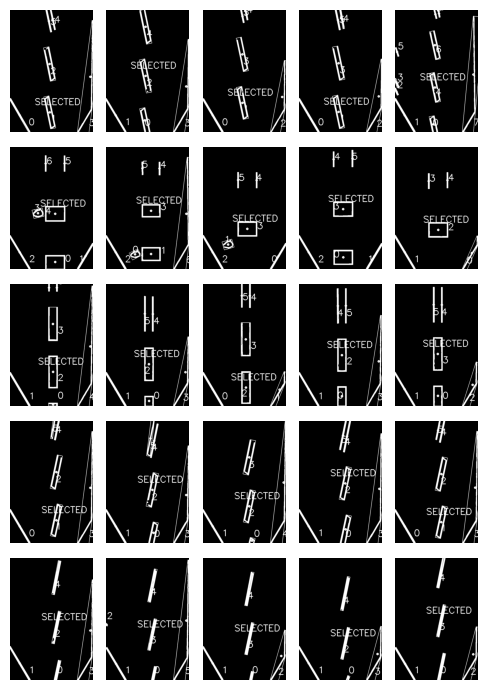

In [55]:
# %%timeit

folder = "imgs"
images = []
imgs_canny = []
imgs_hou = []

for img_name in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, img_name), cv2.IMREAD_GRAYSCALE)
    img, img_blur, img_hou = show_process_image(img)
    # print(f"Steer: {steer:.2f}, \tThrottle: {throttle:.2f}")
    images.append(img)
    # imgs_canny.append(img_canny)
    # imgs_hou.append(img_hou)

show_imgs(images, figsize=(5, 7))
# show_imgs(imgs_canny)
# show_imgs(imgs_hou)

In [ ]:
# %%timeit
# start_time = time.perf_counter()

folder = "imgs/"
images = os.listdir(folder)

img = cv2.imread(os.path.join(folder, images[0]), cv2.IMREAD_GRAYSCALE)
steer, throttle = process_image(img)
    # print(f"Steer: {steer:.2f}, \tThrottle: {throttle:.2f}")

# end_time = time.perf_counter()
# print(f"Time taken: {end_time - start_time:.2f} seconds")